In [1]:
import numpy as np
import json
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset
from torchtext import vocab
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
from random import choice
import random
import pandas as pd
import itertools
random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

# загружаем датасет
img_codes = np.load("/content/drive/My Drive/Stepik_Mipt/Image captioning/data/data/image_codes.npy")
captions = json.load(open('/content/drive/My Drive/Stepik_Mipt/Image captioning/data/data/captions_tokenized.json'))

In [5]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


In [6]:
# Flatten captions
flatten_captions = [sent for cap in captions for sent in cap]

In [7]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, trimmed=True):

        self.trimmed = trimmed
        self.word2index = {"PAD": PAD_token, "SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"PAD": PAD_token, "SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [8]:
def zeroPadding(l, fillvalue=PAD_token, fix_length=15):

    # Consider EOS and SOS tokens
    length = fix_length+2
    
    new_l = []
    for i in l:
        new = i + [PAD_token] * (length-len(i))
        new_l.append(new[:length])
    # return list(itertools.zip_longest(*l, fillvalue=fillvalue))
    return new_l

In [9]:
def indexesFromSentence(voc, sentence):
    return [SOS_token] + [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    # lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    # padVar = torch.LongTensor(padList)
    return padList

In [10]:
# Init Vocabulary 
CAP_VOC = Voc()

# Create Vocabulary in loop
for pair in flatten_captions:
      CAP_VOC.addSentence(pair)

# Choose word frequency treshold
# CAP_VOC.trim(5)

In [11]:
def trimRareWords(voc, data, MIN_COUNT, img_codes):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep = []
    for idx, item in enumerate(data):
        new_item = list()
        input_sentence_1 = item[0]
        input_sentence_2 = item[1]
        input_sentence_3 = item[2]
        input_sentence_4 = item[3]
        input_sentence_5 = item[4]
        keep_input_1 = True
        keep_input_2 = True
        keep_input_3 = True
        keep_input_4 = True
        keep_input_5 = True

        # Check input sentence
        for word in input_sentence_1.split(' '):
            if word not in voc.word2index:
                keep_input_1 = False
                break
        # Check output sentence
        for word in input_sentence_2.split(' '):
            if word not in voc.word2index:
                keep_input_2 = False
                break

        # Check input sentence
        for word in input_sentence_3.split(' '):
            if word not in voc.word2index:
                keep_input_3 = False
                break
        # Check output sentence
        for word in input_sentence_4.split(' '):
            if word not in voc.word2index:
                keep_input_4 = False
                break
                # Check input sentence
        for word in input_sentence_5.split(' '):
            if word not in voc.word2index:
                keep_input_5 = False
                break
        

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        
        if keep_input_1:
            new_item.append(input_sentence_1) 
        if keep_input_2:
            new_item.append(input_sentence_2) 
        if keep_input_3:
            new_item.append(input_sentence_3) 
        if keep_input_4:
            new_item.append(input_sentence_4) 
        if keep_input_5:
            new_item.append(input_sentence_5) 
        

        if len(new_item) == 0:
            img_codes = np.delete(img_codes, idx, axis=0)
            continue
        keep.append(new_item) 


    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(data), len(keep), len(keep) / len(data)))
    return np.array(keep), img_codes

In [13]:
captions, img_codes = trimRareWords(voc=CAP_VOC, data=captions, MIN_COUNT=5, img_codes=img_codes)

keep_words 10399 / 29417 = 0.3535
Trimmed from 118287 pairs to 118275, 0.9999 of total


In [14]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    # print("Length img_codes: ", len(img_codes))
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    # print("random_image_ix: ", random_image_ix)
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = [captions[val] for val in random_image_ix.tolist()]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = inputVar(batch_captions, CAP_VOC)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

### Split dataset in train/eval


In [16]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

## Caption net 

In [88]:
class CaptionNet(nn.Module):
    def __init__(self, vocab_size: int, embed_size=128, hidden_size=256, num_layers=1, cnn_features_size=2048):
        super(CaptionNet, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.cnn_to_h0 = nn.Linear(cnn_features_size, hidden_size)
        self.cnn_to_c0 = nn.Linear(cnn_features_size, hidden_size)

        # embedding layer for captions
        self.embed_cap = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        
        # lstm cell
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, batch_first=True)
    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)

    def forward(self, captions_ix, hidden):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """

       
        embedding_input = self.embed_cap(captions_ix.long()) # (N_batch, seq_len, emb_dim) = (32, 17, 128)    

        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM

        embedding_input = embedding_input.unsqueeze(1)

        lstm_out, hidden = self.lstm(embedding_input, hidden) # shape: [batch, caption_length, lstm_units]
        
        
        # print(lstm_out.size())
        logits = self.fc_out(lstm_out)
        
        
        return logits, hidden

In [89]:
# Define model
n_tokens = CAP_VOC.num_words
network2 = CaptionNet(n_tokens)

# Move to CUDA
assert torch.cuda.is_available()
network2.cuda()

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (embed_cap): Embedding(10402, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc_out): Linear(in_features=256, out_features=10402, bias=True)
  (softmax): Softmax(dim=1)
)

## Train model using train set

In [90]:
def train(batch_size, max_target_len, features, captions, model, criterion, optimizer, n_tokens, teacher_force_ratio=0.5):

    # init the hidden and cell states to zeros
    decoder_hidden = (torch.zeros((1, 1, model.hidden_size)).cuda(), torch.zeros((1, 1, model.hidden_size)).cuda())


    # init output tensor 
    outputs = torch.empty((batch_size, captions.size(1), n_tokens)).cuda()

    # Initial hidden: images vector
    initial_cell = model.cnn_to_c0(features) # shape: (batch_size * 256)
    initial_hid = model.cnn_to_h0(features) 
    decoder_hidden = (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0))

    # First input: <SOS> tokens
    t_captions = captions[:, 0]

    optimizer.zero_grad()

    # print('captions size: ', captions.size())
    # print('features size: ', features.size())
    for t in range(1, max_target_len): # TODO: max_target_len --> captions.size(1)
        

        # Forward batch of sequences through decoder one time step at a time
        decoder_output_logits, decoder_hidden = model(captions_ix=t_captions, hidden=decoder_hidden)

        # Get one time step at a time (all_time_steps=max_target_len=17)
        t_captions = captions[:, t]

        outputs[:, t, :] = decoder_output_logits.squeeze(1)
       
        # Teacher forcing: 
        teacher_force = random.random() < teacher_force_ratio

        top1 = decoder_output_logits.squeeze(1).max(1)[1]

        t_captions = (captions[:, t] if teacher_force else top1)

        

        # decoder_output_softmax = Softmax(decoder_output_logits)
        # print('decoder_output_softmax:' , decoder_output_softmax.size())


    # Calculate the batch loss
    loss = criterion(outputs.view(-1, n_tokens), captions.contiguous().view(-1))
    
    # Backward pass
    loss.backward()
        
    # Update the parameters in the optimizer
    optimizer.step()

    return loss


In [94]:
def trainIters(epoch, model, captions_train_set, images_train_set, batch_size, optimizer, criterion, max_target_len, n_tokens, teacher_force_ratio):

    # epoch losses initializing
    epoch_losses = list()

    model.train()
    
    batch_loss = 0
    loss_epoch = 0


    num_batches = len(captions_train_set)//batch_size

    for batch in range(num_batches):
        
        imgs, caps = generate_batch(images_train_set, captions_train_set, batch_size, max_caption_len=None)

        batch_loss = train(batch_size, max_target_len=max_target_len, features=imgs.cuda(), 
                           captions=caps.cuda(), model=model, criterion=criterion, optimizer=optimizer, n_tokens=n_tokens, 
                           teacher_force_ratio=teacher_force_ratio)
        
        epoch_losses.append(batch_loss.item())
        
    


    loss_epoch = sum(epoch_losses)/num_batches
    print("Epoch {0} --->>> Train Loss {1}".format(epoch, loss_epoch))

In [95]:
# Define optimizer and criterion
optimizer2 = torch.optim.Adam(network2.parameters())

criterion2 = nn.CrossEntropyLoss(ignore_index = PAD_token).cuda()

In [96]:
# Train model
n_epochs = 5
n_tokens = CAP_VOC.num_words
for i in range(n_epochs):
    trainIters(epoch=i, model=network2, captions_train_set=train_captions, images_train_set=train_img_codes, batch_size=32,
               optimizer=optimizer2, criterion=criterion2, max_target_len=17, n_tokens=n_tokens, teacher_force_ratio=0.5)

Epoch 0 --->>> Train Loss 4.398982095058898
Epoch 1 --->>> Train Loss 3.9631084212322087
Epoch 2 --->>> Train Loss 3.8628774229045093
Epoch 3 --->>> Train Loss 3.817699372374144
Epoch 4 --->>> Train Loss 3.7676470329871896


## Evaluate model with evaluation set

In [104]:
def test(batch_size, max_target_len, features, captions, model, criterion, n_tokens, teacher_force_ratio=0.0):

    # init the hidden and cell states to zeros
    decoder_hidden = (torch.zeros((1, 1, model.hidden_size)).cuda(), torch.zeros((1, 1, model.hidden_size)).cuda())


    # init output tensor 
    outputs = torch.empty((batch_size, captions.size(1), n_tokens)).cuda()

    # Initial hidden: images vector
    initial_cell = model.cnn_to_c0(features) # shape: (batch_size * 256)
    initial_hid = model.cnn_to_h0(features) 
    decoder_hidden = (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0))

    # First input: <SOS> tokens
    t_captions = captions[:, 0]



    # print('captions size: ', captions.size())
    # print('features size: ', features.size())
    for t in range(1, max_target_len): # TODO: max_target_len --> captions.size(1)
        

        # Forward batch of sequences through decoder one time step at a time
        decoder_output_logits, decoder_hidden = model(captions_ix=t_captions, hidden=decoder_hidden)

        # Get one time step at a time (all_time_steps=max_target_len=17)
        t_captions = captions[:, t]

        outputs[:, t, :] = decoder_output_logits.squeeze(1)
       
        # Teacher forcing: 
        teacher_force = random.random() < teacher_force_ratio
        
        top1 = decoder_output_logits.squeeze(1).max(1)[1]

        t_captions = (captions[:, t] if teacher_force else top1)


        # decoder_output_softmax = Softmax(decoder_output_logits)
        # print('decoder_output_softmax:' , decoder_output_softmax.size())


    # Calculate the batch loss
    loss = criterion(outputs.view(-1, n_tokens), captions.contiguous().view(-1))
    
    return loss

In [109]:
def testIters(model, criterion, captions_test_set, images_test_set, batch_size, max_target_len, n_tokens, teacher_force_ratio):

    # epoch losses initializing
    epoch_losses = list()

    model.eval()
    
    batch_loss = 0
    loss_epoch = 0

    num_batches = len(captions_test_set)//batch_size

    with torch.no_grad():

        for batch in range(num_batches):
            
            imgs, caps = generate_batch(images_test_set, captions_test_set, batch_size, max_caption_len=None)

            batch_loss = test(batch_size, max_target_len=max_target_len, features=imgs.cuda(),
                                      captions=caps.cuda(), model=model, criterion=criterion, n_tokens=n_tokens, teacher_force_ratio=teacher_force_ratio)
            
            epoch_losses.append(batch_loss.item())
            
        


    loss_epoch = sum(epoch_losses)/num_batches
    print("--->>> Test loss {0}".format(loss_epoch))

In [110]:
# Model evaluation
testIters(model=network2, criterion=criterion2, captions_test_set=val_captions, images_test_set=val_img_codes, batch_size=32, 
          max_target_len=17, n_tokens=n_tokens, teacher_force_ratio=0.0)

--->>> Test loss 4.723412929834712


## Beam search decoding

In [154]:
def beam_search_decoding(batch_size, max_target_len, image, model, n_tokens):

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])

        softmax = torch.nn.Softmax(1)

        # Initial hidden: images vector
        initial_cell = model.cnn_to_c0(vectors_neck.cuda()) # shape: (batch_size * 256)
        initial_hid = model.cnn_to_h0(vectors_neck.cuda()) 
        decoder_hidden = (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0))

        # list to collect outputs
        outputs = []

        # Init caption tensor with ones (one equals SOS index value)
        caption = torch.ones(batch_size, 17, dtype=torch.long).cuda()

        # First input to the decoder is the <sos> tokens
        t_caption = caption[:, 0]


        # Generate caption in loop with max caption length
        for t in range(1, max_target_len): # TODO: max_target_len --> captions.size(1)

            # Forward batch of sequences through decoder one time step at a time
            decoder_output_logits, decoder_hidden = model(captions_ix=t_caption, hidden=decoder_hidden)
            
            # Apply the softmax to the logits to get the probabilities of the characters
            t_caption_prob = softmax(decoder_output_logits.squeeze(1))
            
            # Get the most likely word index
            t_caption = torch.argmax(decoder_output_logits.squeeze(1), 1)

            # Stop decoding if EOS index 
            if t_caption.item() == 2: 
                break

            # Collect decoded indexes
            outputs.append(t_caption.item())

            

    # Decode indexes to words according to vocabulary
    return ' '.join([CAP_VOC.index2word[idx] for idx in outputs])

In [155]:
print(beam_search_decoding(batch_size=1, max_target_len=17, image=img, model=network2, n_tokens=n_tokens))

Collect outputs:  [23]
t after squeeze:  torch.Size([1])
tensor([23], device='cuda:0')
Collect outputs:  [23, 159]
t after squeeze:  torch.Size([1])
tensor([159], device='cuda:0')
Collect outputs:  [23, 159, 14]
t after squeeze:  torch.Size([1])
tensor([14], device='cuda:0')
Collect outputs:  [23, 159, 14, 46]
t after squeeze:  torch.Size([1])
tensor([46], device='cuda:0')
Collect outputs:  [23, 159, 14, 46, 47]
t after squeeze:  torch.Size([1])
tensor([47], device='cuda:0')
Collect outputs:  [23, 159, 14, 46, 47, 93]
t after squeeze:  torch.Size([1])
tensor([93], device='cuda:0')
Collect outputs:  [23, 159, 14, 46, 47, 93, 23]
t after squeeze:  torch.Size([1])
tensor([23], device='cuda:0')
Collect outputs:  [23, 159, 14, 46, 47, 93, 23, 639]
t after squeeze:  torch.Size([1])
tensor([639], device='cuda:0')
Collect outputs:  [23, 159, 14, 46, 47, 93, 23, 639, 11]
t after squeeze:  torch.Size([1])
tensor([11], device='cuda:0')
a brown and white dog standing a fence .


In [143]:
from matplotlib import pyplot as plt

import skimage.transform
%matplotlib inline

#sample image
# !wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRBQzLgIi1xUdyTH_3bgJLj0qf880vL_ajVAA&usqp=CAU -O img.jpg
img = plt.imread('images?q=tbn:ANd9GcRBQzLgIi1xUdyTH_3bgJLj0qf880vL_ajVAA')
img =  skimage.transform.resize(img, (299, 299))

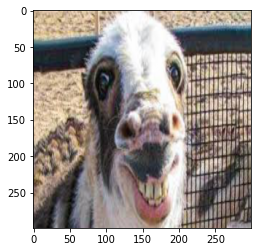

In [144]:
plt.imshow(img) 

## Load Inception model

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [ ]:
# загружаем inseption
inception = beheaded_inception_v3().train(False)

In [ ]:
# http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.
# https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg

/__________________________________________________________________________/


### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size: int, embed_size=128, hidden_size=256, num_layers=1, cnn_features_size=2048):
        super(DecoderRNN, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # embedding layer for images
        self.embed_img = nn.Linear(cnn_features_size, self.embed_size)

        # embedding layer for captions
        self.embed = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_size)
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=embed_size, hidden_size=hidden_size)
    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.vocab_size)
    
        # activations
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, features, captions):
        
        # batch size
        batch_size = features.size(0)
        
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).cuda()
        cell_state = torch.zeros((batch_size, self.hidden_size)).cuda()
    
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).cuda()

        # embed the captions
        captions_embed = self.embed(captions)

        # embed an images
        features = self.embed_img(features)
        
        # pass the caption word by word
        for t in range(captions.size(1)):

            # for the first time step the input is the feature vector
            if t == 0:
                # print("t=0")
                hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
                
            # for the 2nd+ time step, using teacher forcer
            else:
                print('captions_embed size: ', captions_embed[:, t, :].size())
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            
            # output of the attention mechanism
            print("Final hidden state: ", hidden_state.size())
            out = self.fc_out(hidden_state)
            
            # build the output tensor
            outputs[:, t, :] = out
        #print("final tensor with logits: ", outputs.size())
        return outputs
    

    def process_forward(self, mode: str, features, captions):
        out = 0
        if mode in ['train', 'test']:
            out = self.forward(features, captions)
        return out




In [ ]:
n_tokens = CAP_VOC.num_words
network = DecoderRNN(vocab_size=n_tokens)

# Move to CUDA
assert torch.cuda.is_available()
network.cuda()

DecoderRNN(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (embed_img): Linear(in_features=2048, out_features=128, bias=True)
  (embed): Embedding(29417, 128)
  (lstm_cell): LSTMCell(128, 256)
  (fc_out): Linear(in_features=256, out_features=29417, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    # print("Length img_codes: ", len(img_codes))
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    # print("random_image_ix: ", random_image_ix)
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = [captions[val] for val in random_image_ix.tolist()]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = inputVar(batch_captions, CAP_VOC)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

Поделим выборку на train/test:

In [ ]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(network.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = PAD_token).cuda()

In [ ]:
def train2(model, optimizer, criterion, batch_size, captions, img_codes, clip=None):
    
    # get the losses for vizualization
    losses = list()
    val_losses = list()


    model.train()
    
    epoch_loss = 0

    num_batches = len(captions)//batch_size

    for batch in range(num_batches):
        
        imgs, caps = generate_batch(img_codes, captions, batch_size, max_caption_len=None)
        
        optimizer.zero_grad()
        # print("Captions size: ", caps.size())
        # print("batch: ", batch)
        output = model.process_forward(features=imgs.cuda(), captions=caps.cuda(), mode='train')
        
        
        # print('Output size: ', output.size())
        # print("Caps size: ", caps.size())
        # print(caps[1:])
        # print(output.view(-1, output.shape[-1]))
        loss = criterion(output[1:].view(-1, output.shape[-1]), caps[1:].view(-1).cuda()) # output shape after transform
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

        losses.append(loss.item())
        
        # save the losses
        # np.save('losses', np.array(losses))

    return epoch_loss / num_batches

In [ ]:
for i in range(2):
  loss = train2(model=network, optimizer=optimizer, criterion=criterion, batch_size=32, captions=train_captions, img_codes=train_img_codes)
  print("Epoch {0}  --->>>  Loss: {1}".format(i, loss))

KeyboardInterrupt: ignored

## Inseption и получение результатов


In [111]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.inception import Inception3
from warnings import warn

class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x
    
from torch.utils.model_zoo import load_url
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [112]:
# загружаем inseption
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


### Сгенерируем описание

In [ ]:
n_tokens = CAP_VOC.num_words
batch_size = 32

def beam_search_forward(features, captions):
    
    # batch size
    batch_size = features.size(0)
    
    # init the hidden and cell states to zeros
    hidden_state = torch.zeros((batch_size, 256))
    cell_state = torch.zeros((batch_size, 256))

    # define the output tensor placeholder
    outputs = torch.empty((batch_size, captions.size(1), n_tokens))

    # embed the captions
    captions_embed = network.embed(captions.long())
    
    # embed an images
    features = network.embed_img(features)
    
    # pass the caption word by word
    for t in range(captions.size(1)-1):

        # for the first time step the input is the feature vector
        
        hidden_state, cell_state = network.lstm_cell(features, (hidden_state, cell_state))
        features = network.fc_out(hidden_state)
        print(features.size())
        print(features)
        scores, features = torch.max(features, dim=1)
        outputs[:, t, :] = features
        features = self.embed(features.unsqueeze(0))

    return outputs

In [ ]:
def gen_caption(image, caption_prefix=('SOS',), 
                     t=1, sample=True, max_len=17):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])

        caption_prefix = torch.zeros(1, max_len, CAP_VOC.num_words).cuda()
        caption_prefix[:, 0, :] = 1

        out = beam_search_forward(features=vectors_neck, captions=caption_prefix)
        return out

In [ ]:
print(gen_caption(img))

RuntimeError: ignored

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def generate_caption(image, caption_prefix=('SOS',), 
                     t=1, sample=True, max_len=17):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        
        
        caption_prefix = torch.empty((1, max_len, CAP_VOC.num_words)).cuda()
        caption_prefix[:, 0, :] = 1
        indices = []

        # слово за словом генерируем описание картинки
        for _ in range(max_len):
            # 1. представляем caption_prefix в виде матрицы
            # 2. Получить из RNN-ки логиты, передав ей vectors_neck и матрицу из п.1
            # 3. Перевести логиты RNN-ки в вероятности (например, с помощью F.softmax)
            # 4. сэмплировать следующее слово в описании, испольщуя полученные вероятности. Можно сэмплировать жадно 
            # (тупо слово с самой большой вероятностью), можно сэмплировать из распределения
            # 5. Добавляем новое слово в caption_prefix
            # 6. Если RNN-ка сгенерила символ конца предложения, останавливаемся

            # 2
            
            
            print('caption_prefix: ', caption_prefix.size())
            print('vectors_neck: ', vectors_neck.size())
            logits = network(vectors_neck.cuda(), caption_prefix.long().cuda())
            # print(h.size())
            print("Logits size: ", logits.size())

            # 3 logits -> prob
            prob = F.log_softmax(logits, dim=2)
            print("Prob size: ", prob.size())
            print("prob: ", prob)

            # 4 
            # _, argmax = torch.max(logits, 1)
            # index = torch.argmax(prob, dim=1)
            val, index = prob[:, :, 2:].max(dim=2)
            print('index: ', index)
            argmax = index.tolist()[0]
            print("Argmax: ", argmax)

            # 5
            outputs[:, _, :] = argmax[0]
            indices.append(argmax)
            caption_prefix = index.tolist()[0]
            print('Caption_prefix: ', caption_prefix)
            

            if argmax == 2:
                break


    print("Indices: ", indices)        
    return [CAP_VOC.index2word[idx] for idx in indices] #caption_prefix

In [ ]:
 def greedy(self, cnn_out, seq_len = 20):
        ip = cnn_out
        hidden = None
        ids_list = []
        for t in range(seq_len):
            lstm_out, hidden = self.lstm(ip.unsqueeze(1), hidden)
            # generating single word at a time
            linear_out = self.linear(lstm_out.squeeze(1))
            word_caption = linear_out.max(dim=1)[1]
            ids_list.append(word_caption)
            ip = self.word_embeddings(word_caption)
        return ids_list

In [ ]:
for i in range(1):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### Скачаем пару картинок, чтобы проверить качество:

In [ ]:
from matplotlib import pyplot as plt

import skimage.transform
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img =  skimage.transform.resize(img, (299, 299))

--2020-07-01 13:36:10--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.200.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.200.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2020-07-01 13:36:10--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.03s   

2020-07-01 13:36:10 (2.03 MB/s) - ‘img.jpg’ saved [54731/54731]



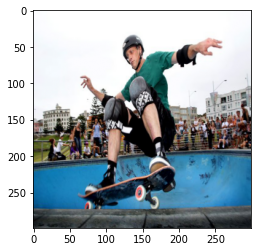

In [ ]:
plt.imshow(img)

In [ ]:
from matplotlib import pyplot as plt

import skimage.transform
%matplotlib inline

#sample image
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img =  skimage.transform.resize(img, (299, 299))

--2020-07-01 14:02:05--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-07-01 14:02:05--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.04s   

2020-07-01 14:02:05 (2.66 MB/s) - ‘img.jpg’ saved [106870/106870]



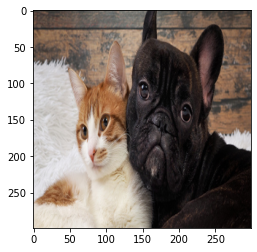

In [ ]:
plt.imshow(img)
plt.show()

--2018-03-18 04:13:41--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K   194KB/s    in 0,5s    

2018-03-18 04:13:42 (194 KB/s) - ‘data/img.jpg’ saved [106870/106870]



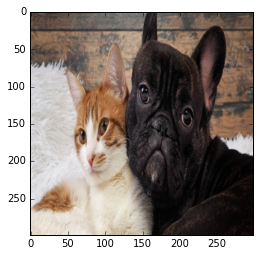

a cat laying down on a bed with a dog .
a cat laying on a bed with a laptop .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed in a bed .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [ ]:
# apply your network on images you've found
#
#